<a href="https://colab.research.google.com/github/gvtsch/Time_series/blob/main/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks (RNNs)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

### Simple example

#### Generating sample dataset

In [37]:
N = 1_000
Tp = 800

t = np.arange(0, N)
x = np.sin(0.02 * t) + 2 * np.random.rand(N)
df = pd.DataFrame(x)
df.head()

,0
0,1.989926
1,1.871616
2,1.352822
3,0.311918
4,1.523579


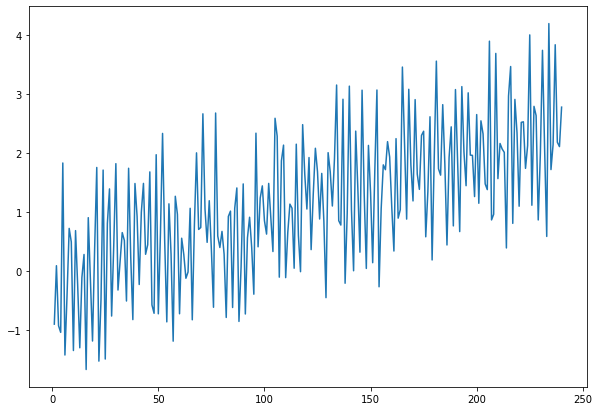

In [72]:
plt.figure(figsize=(10, 7))
plt.plot(df)
plt.show()

#### Split dataset in training and test set

In [39]:
values = df.values
train, test = values[0:Tp,:], values[Tp:N,:]
train[:5], test[:5], train.size, test.size, train.shape, test.shape

(array([[1.98992554],
        [1.87161569],
        [1.3528216 ],
        [0.31191767],
        [1.52357886]]), array([[0.98048862],
        [1.45840964],
        [0.83893573],
        [1.59570296],
        [0.43269361]]), 800, 200, (800, 1), (200, 1))

In [40]:
step = 5
test = np.append(test, np.repeat(test[-1,], step))
train = np.append(train, np.repeat(train[-1,], step))
test.shape, train.shape, train[:5], train[-5:], train.size, test.size, train.shape, test.shape, test[-1], test[-5:]

((205,),
 (805,),
 array([1.98992554, 1.87161569, 1.3528216 , 0.31191767, 1.52357886]),
 array([1.24671961, 1.24671961, 1.24671961, 1.24671961, 1.24671961]),
 805,
 205,
 (805,),
 (205,),
 1.6260910585282178,
 array([1.62609106, 1.62609106, 1.62609106, 1.62609106, 1.62609106]))

In [41]:
# Convert into dataset matrix
def convertToMatrix(data, step):
  X, Y = [], []
  for i in range(len(data)-step):
    d = i + step
    X.append(data[i:d,])
    Y.append(data[d,])
  return np.array(X), np.array(Y)

In [42]:
trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)
trainX[:5], trainY[:5]

(array([[1.98992554, 1.87161569, 1.3528216 , 0.31191767, 1.52357886],
        [1.87161569, 1.3528216 , 0.31191767, 1.52357886, 0.14536481],
        [1.3528216 , 0.31191767, 1.52357886, 0.14536481, 0.44002575],
        [0.31191767, 1.52357886, 0.14536481, 0.44002575, 1.99855806],
        [1.52357886, 0.14536481, 0.44002575, 1.99855806, 1.51739268]]),
 array([0.14536481, 0.44002575, 1.99855806, 1.51739268, 1.15176632]))

In [43]:
# Reshape trainX and testX to fit with the keras model. RNN require 3-D input data.
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(800, 1, 5)

#### Build the RNN

In [44]:
# Simple RNN model
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1, step), activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1))

model.compile(
    loss="mean_squared_error",
    optimizer="rmsprop"
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1216      
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


#### Run and test the model

In [45]:
model.fit(
    trainX, 
    trainY,
    epochs=100,
    batch_size=32,
    verbose=0
)

In [46]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict, testPredict), axis=0)

In [47]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore

0.33963915705680847

#### Plot results

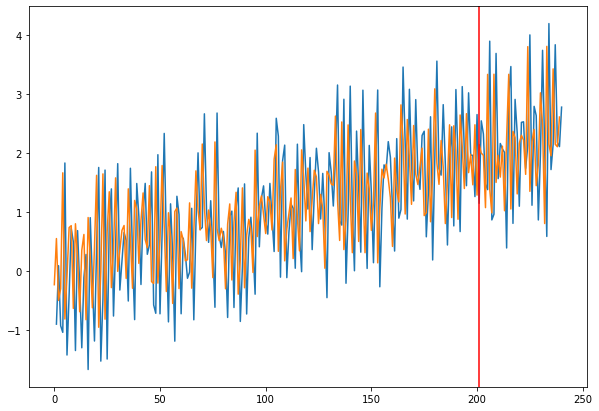

In [73]:
index = df.index.values
plt.figure(figsize=(10, 7))
plt.plot(df)
plt.plot(predicted)
plt.axvline(df.index[Tp], c="r")
plt.show()

## Long Term Short Memory Networks (LSTMs)

The LSTM network is a type of Recurrent Neural Networs (RNN). LSTM network applies memory units to remember RNN outputs. Memory untis contain gates to deal with the output information. The importance of the information is decided by the calculated weights.

* The **forget gate** discards the output if it is useless.
* The **input gate** allows to update the state.
* The **output gate** sends the neurons output.



In [49]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#### Prepare test data
Generate time series data for this example

In [50]:
random.seed(123)
def CreateTSData(N):
  columns = ["value"]
  df = pd.DataFrame(columns=columns)
  for i in range(N):
    v = i/100 + math.sin(2 * i) + random.uniform(-1, 1)
    df.loc[i] = [v]
  return df

In [51]:
N = 240
df = CreateTSData(N)
df.index = np.arange(
    start=1, 
    stop=N+1, 
    step=1)

df.head(), df[-5:]

(      value
 1 -0.895273
 2  0.093671
 3 -0.922319
 4 -1.034015
 5  1.831756,         value
 236  2.145509
 237  3.832785
 238  2.183090
 239  2.109064
 240  2.776743)

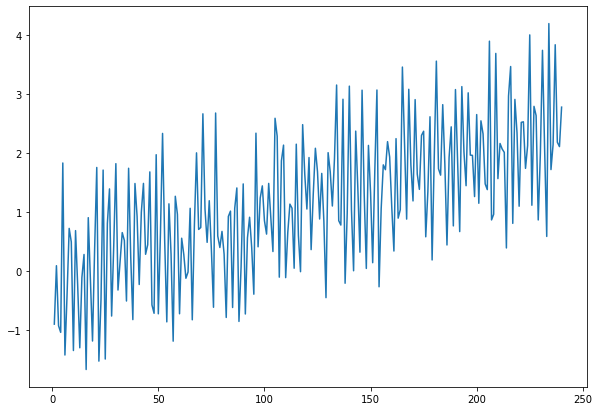

In [74]:
plt.figure(figsize=(10, 7))
plt.plot(df)
plt.show()

#### Split dataset into train and test data

In [53]:
Tp = 200 # training part
values = df.values
train, test = values[0:Tp,:], values[Tp:N,:]

In [54]:
step = 3
test = np.append(test, np.repeat(test[-1,], step))
train = np.append(train, np.repeat(train[-1], step))

In [55]:
trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)
trainX.shape, testX.shape, trainY.shape, testY.shape

((200, 3), (40, 3), (200,), (40,))

In [56]:
# Reshape for to fit with Keras model
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape, testX.shape

((200, 1, 3), (40, 1, 3))

#### Create the LSTM model

In [62]:
model = Sequential()
model.add(LSTM(units=32, input_shape=(1,step), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))

In [63]:
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4608      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


#### Run and test the model

In [64]:
model.fit(trainX,trainY, epochs=100, batch_size=32, verbose=0)

In [67]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict, testPredict), axis=0)

#### Plot results

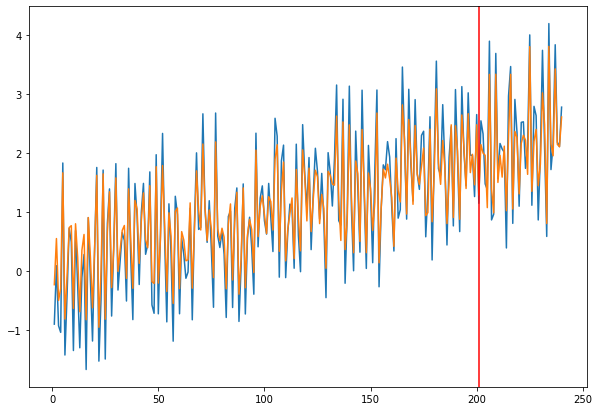

In [75]:
index = df.index.values
plt.figure(figsize=(10, 7))
plt.plot(index, df)
plt.plot(index, predicted)
plt.axvline(df.index[Tp], c="r")
plt.show()

## Physics-guided Neural Networks (PGNNs)

### Karpatne el al.: An Application in Lake Temperature Modeling
Karpatne et al. present to approaches to utlize physics to guide a machine learning model
* Use physics theory, to calculate additional features (**feature engineering**) and feed them into the model along with the measurements
* Add a **physical inconsistency term** to the loss function to punish physically inconsistent predictions
  * Similar to adding a regularization term to punish overfitting
  * Optimization algorithm should also take care of minimizing physically inconsisten results.

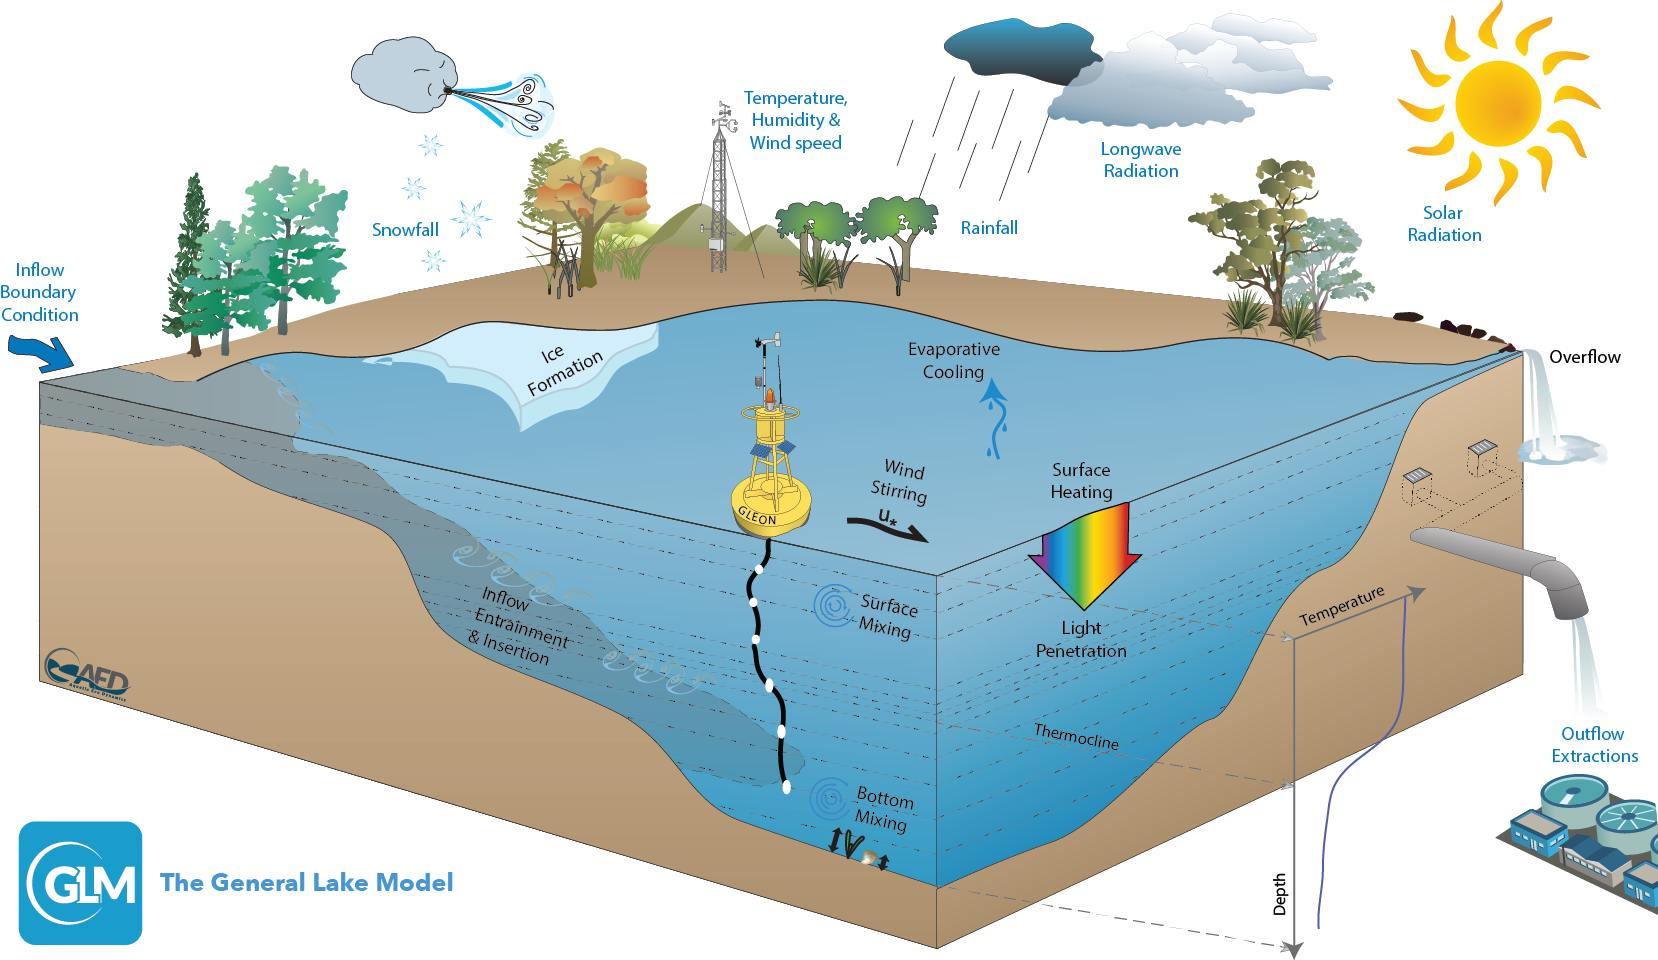

Karpatne et al. combine these to approaches with a neural network to the so called PGNN. PGNNs might provide the following advantages:
* [**Achieving generalization**](https://developers.google.com/machine-learning/crash-course/generalization/video-lecture): Physics models, mostly, do not depend on data and might perform well on unseen data.
* PGNNs could provide a basis to [**Explainable AI**](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) as they represent physically consistent and interpretable results.

In their paper, Karpatne et al. are modeling the temperature of a given lake. The water temperature controls the growth, survival and reproduction of biological species living in the lake. The temperature therefore is crucial.
The task is to create a model that can predict the lake's temperature as a function of depth and time.

**Feature engineering** was applied by using a model, called the [general lake model (GLM)](https://aed.see.uwa.edu.au/research/models/GLM/), to generate new features and feed them into the NN. This model is a physics model that calculates the lake's temperature as a function of heating due to sin, evaporation etc.

**The physical inconsistency term** takes into account, that denser water sinks. The relationship between water temperature and its density is known, too. The deeper the water, the higher the predicted density should be. If not, it is a physical inconsistency. This can be implementated into the loss function. Furthermore it is possible vary the punishment in dependence of the inconsitency's size.

They implemented several models to compare their results:
* **PHY**: Physical model of the lake (GLM)
* **pureDS**:
* **PGNN_0**: A neural network with feature engineering. The results of this model are fed into a the NN as additional features.
* **PGNN**: A neural network with feature engineering and the modified loss function

and two evaluation measures:
* **RMSE**: Root mean squared error
* **Inconsistency**: Fraction of time-steps where the model makes physically inconsistent predictions.

> 💡 **Results**:\
\begin{array}{|c|c|c|c|}\hline
              & PHY  & pureDS & PHNN0   & PGNN  \\ \hline
RMSE          & 2.57 & 1.77   & 1.21    & 1.16  \\ \hline
Inconsistency &      & 50.2\% & 21.61\% & 2.5\% \\ \hline
\end{array}

### Import and view datasets

In [60]:
# Import datasets
import os
if not os.path.exists("mendota.mat"): 
  !wget https://github.com/gvtsch/Time_series/blob/main/Datasets/mendota.mat
if not os.path.exists("mendota_sampled.mat"): 
  !wget https://github.com/gvtsch/Time_series/blob/main/Datasets/mendota_sampled.mat
if not os.path.exists("mille_lacs.mat"): 
  !wget https://github.com/gvtsch/Time_series/blob/main/Datasets/mille_lacs.mat
if not os.path.exists("mille_lacs_sampled.mat"): 
  !wget https://github.com/gvtsch/Time_series/blob/main/Datasets/mille_lacs_sampled.mat

Sources:
* https://resources.experfy.com/ai-ml/physics-guided-neural-networks-pgnns/
* https://arxiv.org/abs/1710.11431